# Tests with Port Angeles data

In [1]:
import sys

import dascore as dc
import h5py
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../')
import functions as f

## Using dascore

In [2]:
# file= r"D:\CSM\Mines_Research\Test_data\Port_Angeles\Cascadia_DAS_1078DT_25PR_14GL_5DEC_2023-05-01T122349Z.h5"
# file= r"D:\CSM\Mines_Research\Test_data\Port_Angeles\Cascadia_DAS_1078DT_25PR_14GL_5DEC_2023-04-25T112349Z.h5"
file= r"D:\CSM\Mines_Research\Test_data\Port_Angeles\Cascadia_DAS_1078DT_25PR_14GL_5DEC_2023-06-01T074209Z.h5"

In [3]:
patch = dc.spool(file)[0]
# patch = patch.detrend("distance")
patch = patch.pass_filter(time=(None, 200))

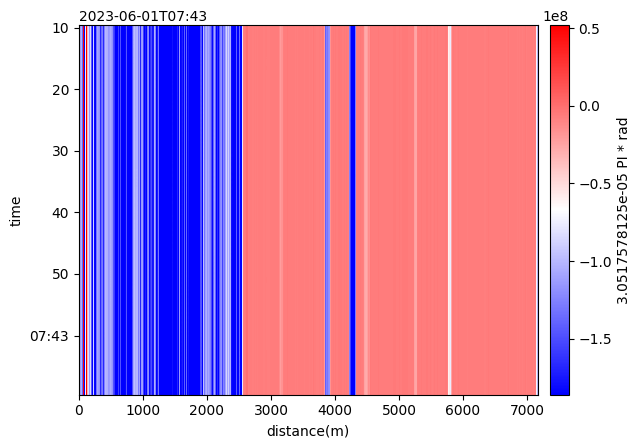

<Axes: xlabel='distance(m)', ylabel='time'>

In [4]:
patch.viz.waterfall(show=True, scale=0.1)

In [5]:
data_path = r"D:\CSM\Mines_Research\Test_data\Port_Angeles"
spool = dc.spool(data_path)

In [6]:
contents = spool.get_contents()
print(contents)

                    time_min file_version experiment_id instrument_id  \
0 2023-06-01 07:33:09.613200          2.0                               
1 2023-06-01 07:34:09.613200          2.0                               
2 2023-06-01 07:35:09.613200          2.0                               
3 2023-06-01 07:36:09.613200          2.0                               
4 2023-06-01 07:37:09.613200          2.0                               
5 2023-06-01 07:38:09.613200          2.0                               
6 2023-06-01 07:39:09.613200          2.0                               
7 2023-06-01 07:40:09.613200          2.0                               
8 2023-06-01 07:41:09.613200          2.0                               
9 2023-06-01 07:42:09.613200          2.0                               

            dims              time_step  \
0  time,distance 0 days 00:00:00.002000   
1  time,distance 0 days 00:00:00.002000   
2  time,distance 0 days 00:00:00.002000   
3  time,distance 0 days 

Set up parameters for coherence analysis

In [7]:
averaging_window = 60
sub_window_length = 2
overlap = 0
samples_per_sec = 500
method = "exact"
start_channel = 1
n_channels = 200

Implement the coherence analysis

In [8]:
# chunk the spool into averaging_window length
spool = spool.chunk(time=averaging_window)

# subselect n_channels number of channels starting from start_channel
sub_spool = spool.select(distance=(start_channel,start_channel+n_channels), samples=True)

# another way to subselect channels
# sub_patch = patch.select(distance=np.array([0, 12, 10, 9]), samples=True)

# perform coherence calculation on each patch
map_out = sub_spool.map(lambda x: f.coherence(x.data.T, sub_window_length,
                overlap,
                sample_interval=1 / samples_per_sec,
                method=method,))

Output()

d:\CSM\Mines_Research\Repositories\Coherence_Analyses\.venv\Lib\site-packages\dascore\viz\waterfall.py:32: RuntimeWarning: overflow encountered in scalar subtract
  modifier = 0.5 * (np.nanmax(data) - np.nanmin(data))


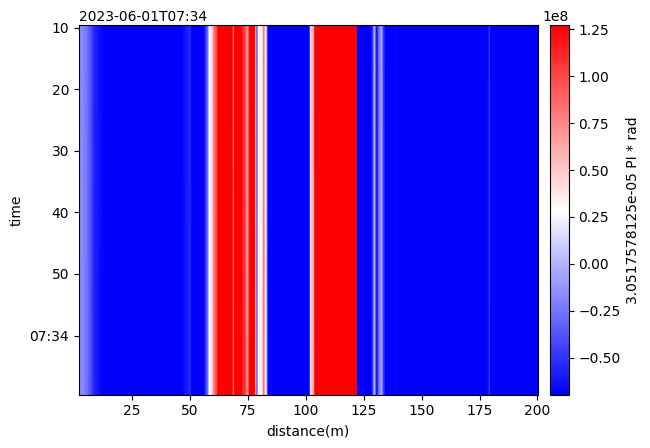

<Axes: xlabel='distance(m)', ylabel='time'>

In [9]:
sub_spool[0].viz.waterfall(show=True, scale=0.1)

In [10]:
detection_significance = np.stack([a[0] for a in map_out], axis=-1)
eig_estimates = np.stack([a[1] for a in map_out], axis=-1)

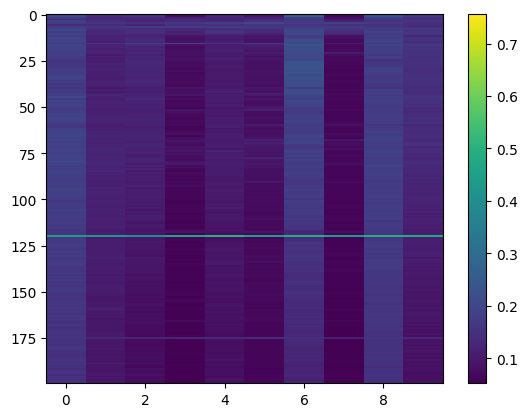

In [11]:
plt.imshow(detection_significance, aspect='auto', interpolation='none')
plt.colorbar()

## Exploring the h5 file

In [12]:
f = h5py.File(file, 'r')

In [13]:
list(f.keys())

['Acquisition']

In [14]:
list(f['Acquisition'].keys())

['Custom', 'Raw[0]']

In [15]:
f['Acquisition']['Raw[0]'].keys()

<KeysViewHDF5 ['Custom', 'RawData', 'RawDataTime']>

In [16]:
# f['Acquisition']['Raw[0]']['RawData']
f['Acquisition']['Raw[0]']['RawDataTime']

<HDF5 dataset "RawDataTime": shape (30000,), type "<i8">

In [17]:
data = np.array(f['Acquisition']['Raw[0]']['RawData'])
timestamp_arr = np.array(f['Acquisition']['Raw[0]']['RawDataTime'])

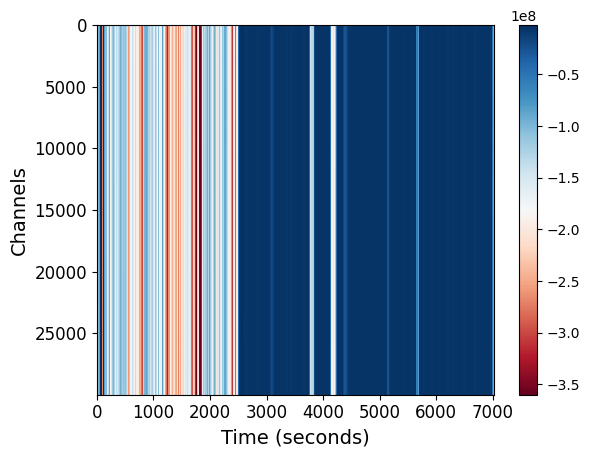

In [18]:
v_min = np.percentile(data, 0.5)
v_max = np.percentile(data, 99)
tick_size = 12
fsize = 14

fig2 = plt.figure()
img2 = plt.imshow(data, cmap="RdBu",
           vmin=v_min, 
           vmax=v_max, aspect='auto', interpolation='none')
         #   extent=(0, 90, 5000, 1))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Channels',fontsize=fsize)
# plt.title('Background noise',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=tick_size)

In [19]:
timestamp_arr

array([1685605329613200, 1685605329615200, 1685605329617200, ...,
       1685605389607200, 1685605389609200, 1685605389611200], dtype=int64)